In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from mpmath import *
from sympy import *
from numpy import linalg as LA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
normalization = 255

In [3]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [4]:
def normalize(X):
    return X / normalization

In [5]:
def denormalize(X):
    return X * normalization

In [ ]:
def show_samples(X, nrows=5, ncols=5, rsize=5, csize=5):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='col', sharey='row', 
                           gridspec_kw={'hspace': -0.02, 'wspace': -0.02}, figsize=(rsize, csize))

    counter=0
    for row in ax:
        for col in row:
            col.imshow(X[counter], 'gray')
            col.axis('off')
            counter += 1
    plt.show()

In [7]:
filename_test = "./data/digit-recognizer/test.csv"
filename_train = "./data/digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


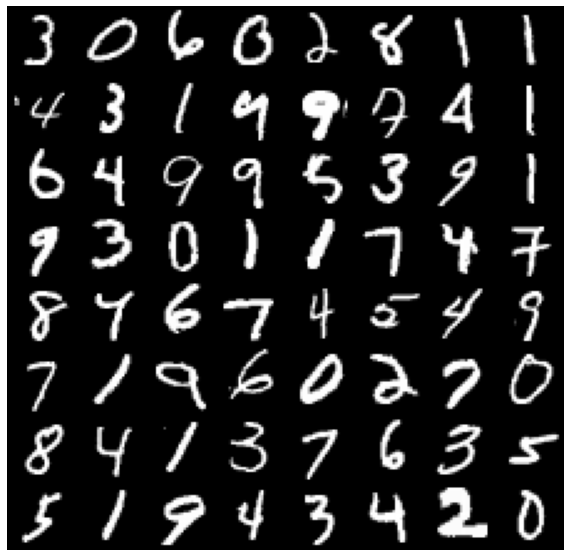

In [10]:
X_show = X_train.to_numpy().reshape(-1,28,28)
show_samples(X_show, nrows=8, ncols=8, rsize=10, csize=10)

In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)

Y_train = encoder.transform(y_train).toarray()
y_labels = [x[3:] for x in  encoder.get_feature_names()]

# encoder.fit(y_test)
# Y_test = encoder.transform(y_test).toarray()

0 iteration: 98.68221827117335


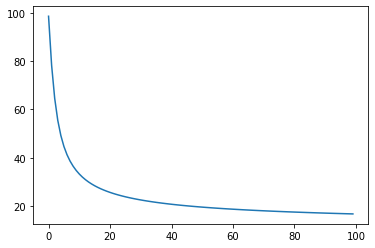

16.685426495968233
Wall time: 3.88 s


In [13]:
%%time
from LogisticRegression import CustomLogisticRegression
lg = CustomLogisticRegression(normalize=False)
lg.fit(normalize(X_train), Y_train, 0.5, 100, 1e-15)

plot_J(lg.get_cost_history())
print(lg.get_cost_history()[-1])

In [14]:
y_pred = lg.predict(normalize(X_test))
y_pred

array([4, 4, 5, ..., 6, 1, 0])

In [60]:
from matplotlib import rc
def show_adversarial_sample(x, y_labels, true_class=[], model=None, attack_model=None, max_norm=10, max_iters=10):

    x_normalized = normalize(x)
    attack = attack_model()

    if type(attack).__name__ in ['AttackNoise']:
        x_adv_normalized = attack.attack(x_normalized, true_class, model.predict, max_norm=max_norm)
    
    elif type(attack).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackFGSM', 'AttackDeepFool', 'AttackMIFGSM']:
        x_adv_normalized = attack.attack(x_normalized, model.W, model.b, true_class, model.predict, max_norm=max_norm)
    
    elif type(attack).__name__ in ['AttackMIFGSM']:
        x_adv_normalized = attack.attack(x_normalized, model.W, model.b, true_class, model.predict, max_norm=max_norm, momentum=0.99)
        
    x_adv = denormalize(x_adv_normalized)
    x_adv_pred = model.predict(np.array(x_adv_normalized))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, sharex=True, sharey=True)
    fig.set_size_inches(15,5)
    fig.suptitle('Adversarial example')
    
    ax1.imshow(x.reshape(28,28), 'gray')
    ax1.set_title(f"Original\n prediction: {model.predict(x_normalized)[0]}")
    
    ax2.imshow(x.reshape(28,28) - x_adv.reshape(28,28), "gray")
    ax2.set_title(f"Difference")
    
    ax3.imshow(x_adv.reshape(28,28), 'gray')
    ax3.set_title(f"Adversarial\n prediction: {x_adv_pred[0]}")
    plt.show()

    pred_with_labels = model.predict_by_labels(np.array(x_adv_normalized), y_labels)
    plt.bar(pred_with_labels[0].keys(), pred_with_labels[0].values())
    plt.show()
    
    print(f"Norm_inf: {LA.norm(abs(x_normalized - x_adv_normalized), np.inf)}; Result: {attack.tricked}")
    print(f"Max value: {max(max(x_adv))}")
    print(f"Min value: {min(min(x_adv))}")

In [61]:
def untargeted_attack_benchmark(X, y_labels, model=None, attack_model=None, samples=100):
    X_norm = normalize(X)
    iter_res_dict = {}

    norms_range = np.linspace(0, 0.5, num=100)
    print(f"Perturbations list: {norms_range}")

    for i in range(samples):
        x_normalized = np.expand_dims(X_norm.iloc[i, :], axis=0)
        y = np.zeros(len(y_labels))
        true_class_pos = model.predict(x_normalized)
        y[true_class_pos] = 1
    
        for norm in norms_range:
            attack = attack_model()
            if type(attack).__name__ in ['AttackNoise']:
                a = attack.attack(x_normalized, y, model.predict, max_norm=norm)
            elif type(attack).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackDeepFool', 'AttackFGSM', 'AttackMIFGSM']:
                a = attack.attack(x_normalized, model.W, model.b, y, model.predict, max_norm=norm)
                
            success = attack.tricked
            
            if norm in iter_res_dict.keys():
                iter_res_dict[norm]["appearance_count"] += 1
                iter_res_dict[norm]["success_count"] += success
            else:
                iter_res_dict.update({norm: {"appearance_count": 1, "success_count": success} })

    success_rate = {}
    for key, value in iter_res_dict.items():
        success_rate[key] = value["success_count"] / value["appearance_count"] * 100

    perturbations_list = [x[0] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]
    successrate_list = [x[1] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]

    plt.plot(perturbations_list, successrate_list)    
    return perturbations_list, successrate_list

In [62]:
correct_pred_idx = np.array(y_test.iloc[:, 0]) == y_pred

In [63]:
from attacks import AttackFGSM
from attacks import AttackIFGSM
from attacks import AttackMIFGSM
from attacks import AttackTIFGSM
from attacks import AttackDeepFool
from attacks import AttackNoise

### Targeted FGSM Benchmark

Perturbations list: [0.         0.00505051 0.01010101 0.01515152 0.02020202 0.02525253
 0.03030303 0.03535354 0.04040404 0.04545455 0.05050505 0.05555556
 0.06060606 0.06565657 0.07070707 0.07575758 0.08080808 0.08585859
 0.09090909 0.0959596  0.1010101  0.10606061 0.11111111 0.11616162
 0.12121212 0.12626263 0.13131313 0.13636364 0.14141414 0.14646465
 0.15151515 0.15656566 0.16161616 0.16666667 0.17171717 0.17676768
 0.18181818 0.18686869 0.19191919 0.1969697  0.2020202  0.20707071
 0.21212121 0.21717172 0.22222222 0.22727273 0.23232323 0.23737374
 0.24242424 0.24747475 0.25252525 0.25757576 0.26262626 0.26767677
 0.27272727 0.27777778 0.28282828 0.28787879 0.29292929 0.2979798
 0.3030303  0.30808081 0.31313131 0.31818182 0.32323232 0.32828283
 0.33333333 0.33838384 0.34343434 0.34848485 0.35353535 0.35858586
 0.36363636 0.36868687 0.37373737 0.37878788 0.38383838 0.38888889
 0.39393939 0.3989899  0.4040404  0.40909091 0.41414141 0.41919192
 0.42424242 0.42929293 0.43434343 0.4393939

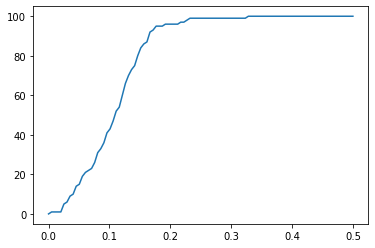

In [64]:
x1, y1 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackIFGSM, samples=100)

Perturbations list: [0.         0.00505051 0.01010101 0.01515152 0.02020202 0.02525253
 0.03030303 0.03535354 0.04040404 0.04545455 0.05050505 0.05555556
 0.06060606 0.06565657 0.07070707 0.07575758 0.08080808 0.08585859
 0.09090909 0.0959596  0.1010101  0.10606061 0.11111111 0.11616162
 0.12121212 0.12626263 0.13131313 0.13636364 0.14141414 0.14646465
 0.15151515 0.15656566 0.16161616 0.16666667 0.17171717 0.17676768
 0.18181818 0.18686869 0.19191919 0.1969697  0.2020202  0.20707071
 0.21212121 0.21717172 0.22222222 0.22727273 0.23232323 0.23737374
 0.24242424 0.24747475 0.25252525 0.25757576 0.26262626 0.26767677
 0.27272727 0.27777778 0.28282828 0.28787879 0.29292929 0.2979798
 0.3030303  0.30808081 0.31313131 0.31818182 0.32323232 0.32828283
 0.33333333 0.33838384 0.34343434 0.34848485 0.35353535 0.35858586
 0.36363636 0.36868687 0.37373737 0.37878788 0.38383838 0.38888889
 0.39393939 0.3989899  0.4040404  0.40909091 0.41414141 0.41919192
 0.42424242 0.42929293 0.43434343 0.4393939

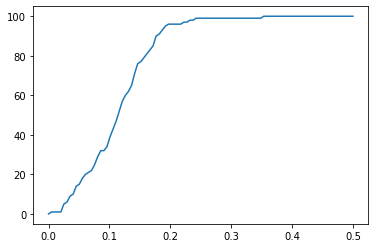

In [65]:
x2, y2 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackFGSM, samples=100)


Perturbations list: [0.         0.00505051 0.01010101 0.01515152 0.02020202 0.02525253
 0.03030303 0.03535354 0.04040404 0.04545455 0.05050505 0.05555556
 0.06060606 0.06565657 0.07070707 0.07575758 0.08080808 0.08585859
 0.09090909 0.0959596  0.1010101  0.10606061 0.11111111 0.11616162
 0.12121212 0.12626263 0.13131313 0.13636364 0.14141414 0.14646465
 0.15151515 0.15656566 0.16161616 0.16666667 0.17171717 0.17676768
 0.18181818 0.18686869 0.19191919 0.1969697  0.2020202  0.20707071
 0.21212121 0.21717172 0.22222222 0.22727273 0.23232323 0.23737374
 0.24242424 0.24747475 0.25252525 0.25757576 0.26262626 0.26767677
 0.27272727 0.27777778 0.28282828 0.28787879 0.29292929 0.2979798
 0.3030303  0.30808081 0.31313131 0.31818182 0.32323232 0.32828283
 0.33333333 0.33838384 0.34343434 0.34848485 0.35353535 0.35858586
 0.36363636 0.36868687 0.37373737 0.37878788 0.38383838 0.38888889
 0.39393939 0.3989899  0.4040404  0.40909091 0.41414141 0.41919192
 0.42424242 0.42929293 0.43434343 0.4393939

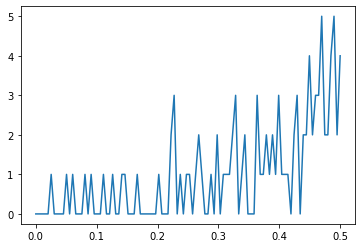

In [66]:
x3, y3 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackNoise, samples=100)

Perturbations list: [0.         0.00505051 0.01010101 0.01515152 0.02020202 0.02525253
 0.03030303 0.03535354 0.04040404 0.04545455 0.05050505 0.05555556
 0.06060606 0.06565657 0.07070707 0.07575758 0.08080808 0.08585859
 0.09090909 0.0959596  0.1010101  0.10606061 0.11111111 0.11616162
 0.12121212 0.12626263 0.13131313 0.13636364 0.14141414 0.14646465
 0.15151515 0.15656566 0.16161616 0.16666667 0.17171717 0.17676768
 0.18181818 0.18686869 0.19191919 0.1969697  0.2020202  0.20707071
 0.21212121 0.21717172 0.22222222 0.22727273 0.23232323 0.23737374
 0.24242424 0.24747475 0.25252525 0.25757576 0.26262626 0.26767677
 0.27272727 0.27777778 0.28282828 0.28787879 0.29292929 0.2979798
 0.3030303  0.30808081 0.31313131 0.31818182 0.32323232 0.32828283
 0.33333333 0.33838384 0.34343434 0.34848485 0.35353535 0.35858586
 0.36363636 0.36868687 0.37373737 0.37878788 0.38383838 0.38888889
 0.39393939 0.3989899  0.4040404  0.40909091 0.41414141 0.41919192
 0.42424242 0.42929293 0.43434343 0.4393939

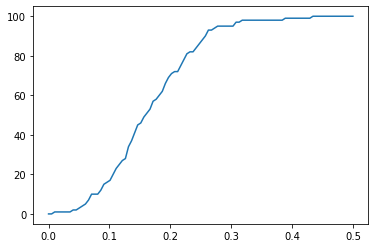

In [67]:
x4, y4 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackDeepFool, samples=100)

Perturbations list: [0.         0.00505051 0.01010101 0.01515152 0.02020202 0.02525253
 0.03030303 0.03535354 0.04040404 0.04545455 0.05050505 0.05555556
 0.06060606 0.06565657 0.07070707 0.07575758 0.08080808 0.08585859
 0.09090909 0.0959596  0.1010101  0.10606061 0.11111111 0.11616162
 0.12121212 0.12626263 0.13131313 0.13636364 0.14141414 0.14646465
 0.15151515 0.15656566 0.16161616 0.16666667 0.17171717 0.17676768
 0.18181818 0.18686869 0.19191919 0.1969697  0.2020202  0.20707071
 0.21212121 0.21717172 0.22222222 0.22727273 0.23232323 0.23737374
 0.24242424 0.24747475 0.25252525 0.25757576 0.26262626 0.26767677
 0.27272727 0.27777778 0.28282828 0.28787879 0.29292929 0.2979798
 0.3030303  0.30808081 0.31313131 0.31818182 0.32323232 0.32828283
 0.33333333 0.33838384 0.34343434 0.34848485 0.35353535 0.35858586
 0.36363636 0.36868687 0.37373737 0.37878788 0.38383838 0.38888889
 0.39393939 0.3989899  0.4040404  0.40909091 0.41414141 0.41919192
 0.42424242 0.42929293 0.43434343 0.4393939

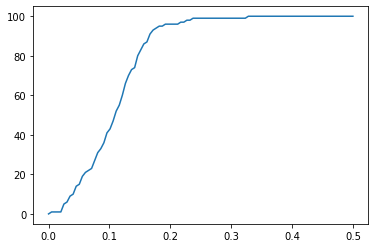

In [68]:
x5, y5 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackMIFGSM, samples=100)

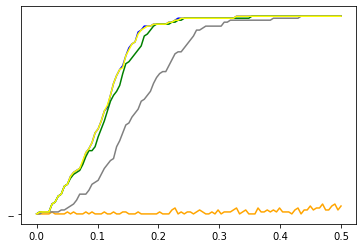

In [69]:
plt.plot(np.array(x1), y1, 'blue', '--')
plt.plot(np.array(x2), y2, 'green', '--')
plt.plot(np.array(x3), y3, 'orange', '--')
plt.plot(np.array(x4), y4, 'gray', '--')
plt.plot(np.array(x5), y5, 'yellow', '--')

### Untargeted Noise Attack

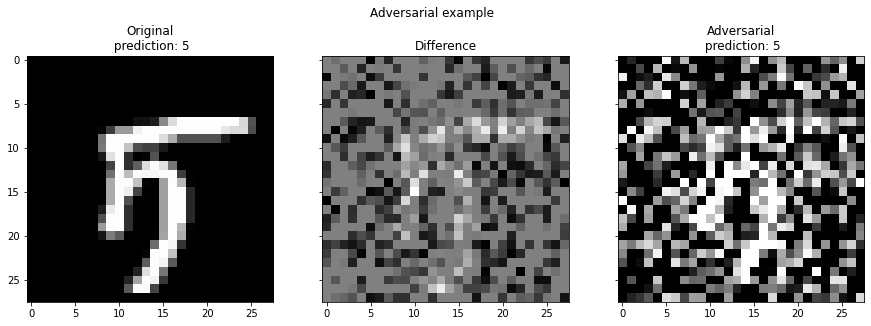

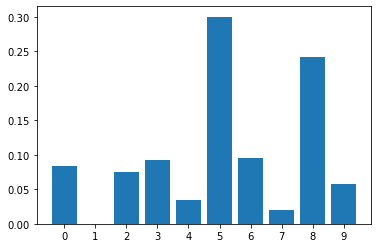

Norm_inf: 215.00001823960102; Result: False
Max value: 255.0
Min value: 0.0


In [70]:
index = 38
x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackNoise, max_norm=1)

### Untargeted FGSM

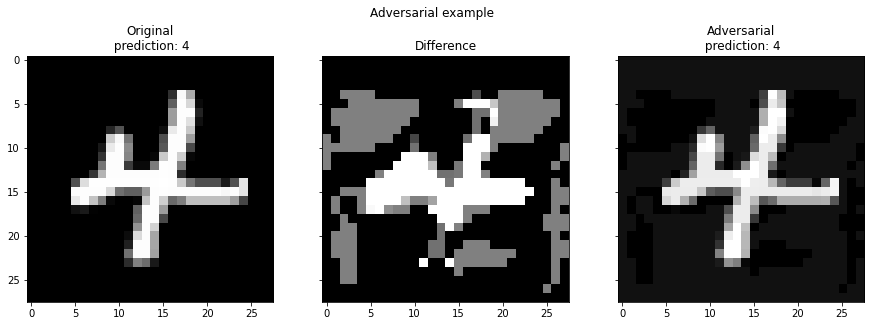

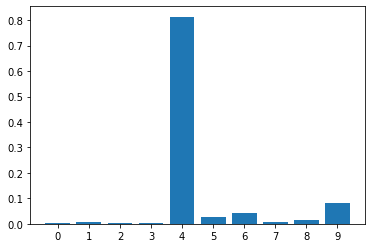

Norm_inf: 41.634509803921574; Result: False
Max value: 255.0
Min value: 0.0


In [71]:
index = 0
x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackFGSM, max_norm=0.07)

### Untargeted I-FGSM

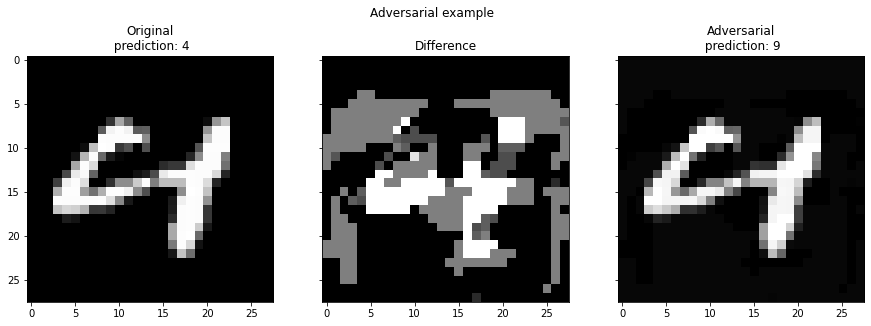

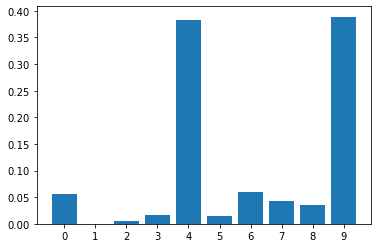

Norm_inf: 16.91980392156863; Result: True
Max value: 255.0
Min value: 0.0


In [72]:
index = 1
x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_norm=0.04, max_iters=100)

### DeepFool

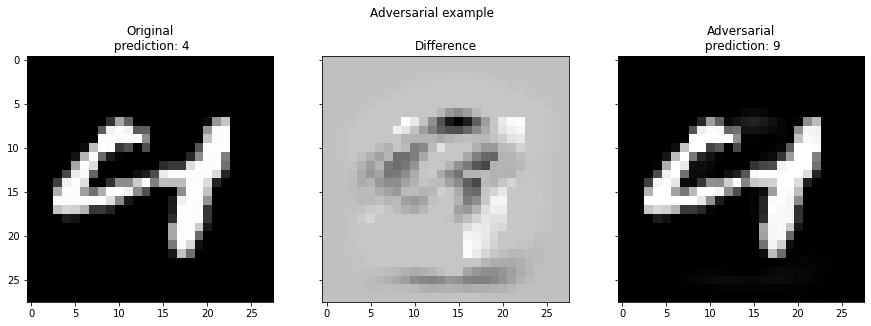

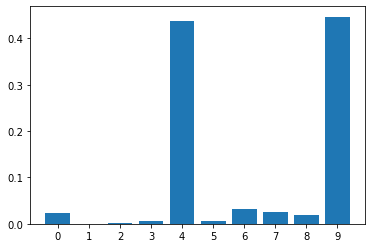

Norm_inf: 7.1284751384620435; Result: True
Max value: 255.0
Min value: 0.0


In [86]:
index = 1
x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackDeepFool, max_norm=0.15, max_iters=12)

### Targeted I-FGSM

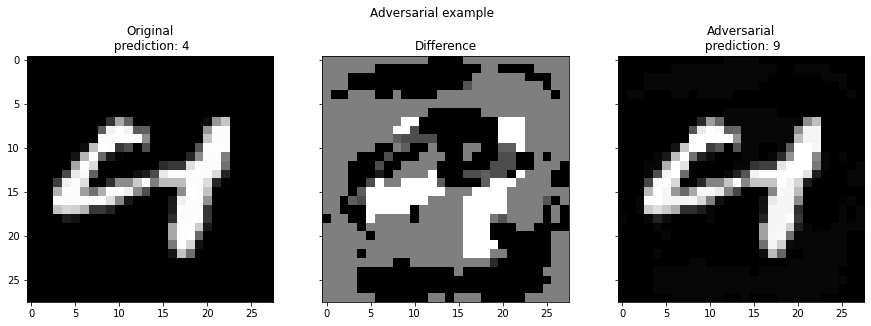

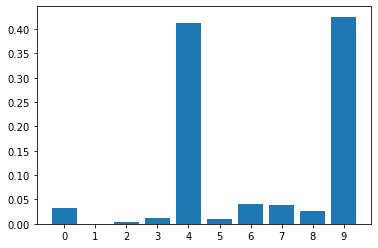

Norm_inf: 10.79764705882353; Result: True
Max value: 255.0
Min value: 0.0


In [74]:
index = 1
x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
y = np.zeros(len(y_labels))
y[9] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackTIFGSM, max_norm=0.2, max_iters=5000)

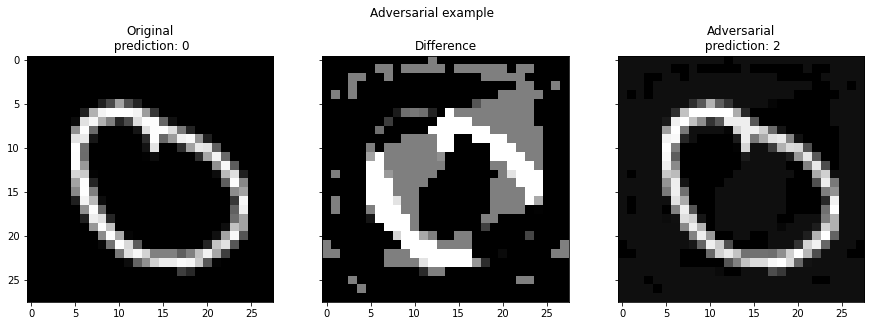

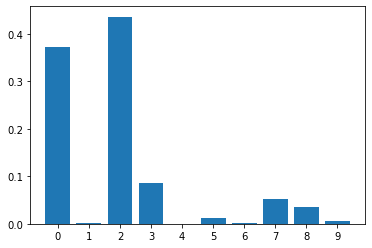

Norm_inf: 36.376274509803935; Result: True
Max value: 255.0
Min value: 0.0


In [75]:
index = 123
x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackMIFGSM, max_norm=1, max_iters=5000)

In [76]:
y_real = np.array(y_test.iloc[:, 0])

comp = pd.DataFrame({"y_pred": y_pred, "y_real": y_real})
print(comp.head(20))

    y_pred  y_real
0        4       4
1        4       4
2        5       9
3        6       6
4        2       2
5        9       9
6        2       2
7        0       0
8        8       8
9        2       2
10       1       1
11       1       7
12       2       2
13       3       3
14       6       6
15       0       0
16       8       8
17       9       7
18       3       3
19       2       2


In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
r2 = r2_score(y_real, y_pred)
accuracy = int(sum(y_real == y_pred) / len(y_pred) * 100)

print(f'Coefficient of determination: {r2}')
print(f"Accuracy: {accuracy}%")

Coefficient of determination: 0.7703952167002182
Accuracy: 88%


In [78]:
# import numpy as np
# import matplotlib.pyplot as plt


# # Example data
# t = np.arange(0.0, 1.0 + 0.01, 0.01)
# s = np.cos(4 * np.pi * t) + 2

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.plot(t, s)

# plt.xlabel(r'\textbf{time} (s)')
# plt.ylabel(r'\textit{voltage} (mV)',fontsize=16)
# plt.title(r"\TeX\ is Number "
#           r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
#           fontsize=16, color='gray')
# # Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)

# # plt.savefig('tex_demo')
# # plt.show()